In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # Para la barra de progreso
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Montamos la unidad de drive y trabajamos con los datasets y modelos preparados
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
models_list = []
train_losses_list = []
train_accuracies_list = []
val_losses_list = []
val_accuracies_list = []

In [ ]:
# @title Carga datos
datasetdir = '/content/drive/MyDrive/cbis-ddsm'
X_train_1 = torch.load(datasetdir + "/X_train_balanced.pt")
y_train_1 = torch.load(datasetdir + "/y_train_balanced.pt")
X_test_1 = torch.load(datasetdir + "/X_test.pt")
y_test_1 = torch.load(datasetdir + "/y_test.pt")

X_tensor = torch.load("/content/drive/MyDrive/output/X_oversampled.pt")
y_tensor = torch.load("/content/drive/MyDrive/output/y_oversampled.pt")

from sklearn.model_selection import train_test_split
test_size = 0.2
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tensor, y_tensor, test_size=test_size, random_state=42)

X_train_full = torch.cat((X_train_1, X_train_2), dim=0)
y_train_full = torch.cat((y_train_1, y_train_2), dim=0)
X_test_full = torch.cat((X_test_1, X_test_2), dim=0)
y_test_full = torch.cat((y_test_1, y_test_2), dim=0)

# Dataset y DataLoader

X_train = X_train_full
y_train = y_train_full
X_test = X_test_full
y_test = y_test_full

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test, y_test)  # Conjunto de validación
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

print("Conjunto de entrenamiento:", X_train.shape)
print("Etiquetas de entrenamiento:", y_train.shape)
print("Conjunto de prueba:", X_test.shape)
print("Etiquetas de prueba:", y_test.shape)

Conjunto de entrenamiento: torch.Size([9916, 1, 224, 224])
Etiquetas de entrenamiento: torch.Size([9916])
Conjunto de prueba: torch.Size([2060, 1, 224, 224])
Etiquetas de prueba: torch.Size([2060])


In [ ]:
X_train_np = X_train.numpy()
y_train_np = y_train.numpy()
X_test_np = X_test.numpy()
y_test_np = y_test.numpy()

# Reordenar dimensiones de X de [N, 1, 224, 224] a [N, 224, 224, 1]
X_train = tf.transpose(X_train_np, perm=[0, 2, 3, 1])
X_test = tf.transpose(X_test_np, perm=[0, 2, 3, 1])

num_classes = 2
y_train = tf.keras.utils.to_categorical(y_train_np, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_np, num_classes)

In [ ]:
print('X train shape : {}' .format(X_train.shape))
print('y train shape : {}' .format(y_train.shape))
print('X test shape : {}' .format(X_test.shape))
print('y test shape : {}' .format(y_test.shape))

X train shape : (9916, 224, 224, 1)
y train shape : (9916, 2)
X test shape : (2060, 224, 224, 1)
y test shape : (2060, 2)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = 256
'''
data_augmentation = Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomBrightness(0.1, value_range=(0.0, 1.0)),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(X_train_mass)
'''
modelMass = Sequential()
#modelMass.add(data_augmentation)
modelMass.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(columnas, filas, 3)))
modelMass.add(MaxPooling2D(strides=2))
modelMass.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
modelMass.add(MaxPooling2D((3, 3), strides=2))
modelMass.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
modelMass.add(MaxPooling2D((3, 3), strides=2))
modelMass.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
modelMass.add(MaxPooling2D((3, 3), strides=2))
modelMass.add(Flatten())
modelMass.add(Dense(128, activation='relu'))
modelMass.add(Dense(2, activation='softmax'))

modelMass.summary()

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),  # Ajuste de brillo
    horizontal_flip=True,
    vertical_flip=True,  # Volteo vertical
    fill_mode='nearest'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
modelMass.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#datagen.fit(X_train_mass)

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical

modelCNN = models.Sequential([
    layers.Conv2D(32, kernel_size=3, padding='same', input_shape=(224, 224, 1)),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Conv2D(64, kernel_size=3, padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Conv2D(128, kernel_size=3, padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Conv2D(128, kernel_size=3, padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2, strides=2),

    layers.Flatten(),
    layers.Dense(128),
    layers.ReLU(),
    layers.Dense(2, activation='softmax')
])

modelCNN.summary()
modelCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

historyFull = modelCNN.fit(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 re_lu_25 (ReLU)             (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 re_lu_26 (ReLU)             (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                               

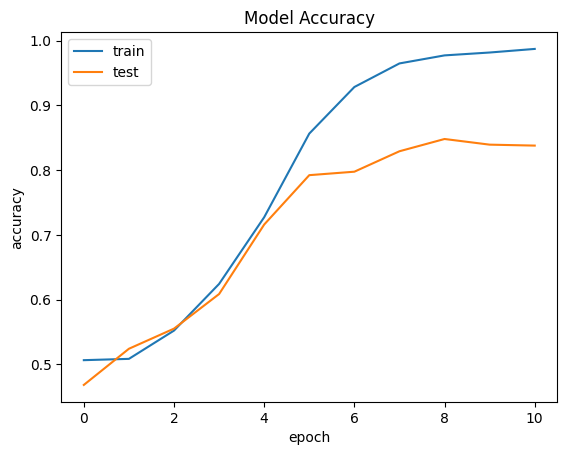

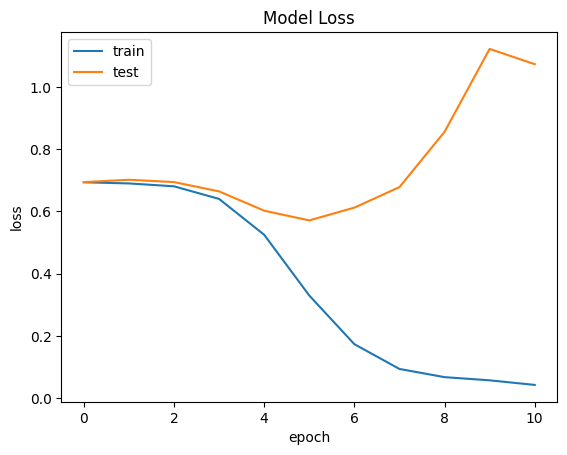

In [ ]:
plt.plot(historyFull.history['accuracy'])
plt.plot(historyFull.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(historyFull.history['loss'])
plt.plot(historyFull.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
modelEnhancedCNN = models.Sequential([
    # Primera capa
    layers.Conv2D(32, kernel_size=3, padding='same', input_shape=(224, 224, 1)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.3),

    # Segunda capa
    layers.Conv2D(64, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.3),

    # Tercera capa
    layers.Conv2D(128, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.3),

    # Cuarta capa
    layers.Conv2D(256, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

modelEnhancedCNN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu_30 (ReLU)             (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 112, 112, 64)    

In [ ]:
modelEnhancedCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

historyEnhancedCNN = modelEnhancedCNN.fit(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/25
620/620 [==============================] - 53s 76ms/step - loss: 0.8002 - accuracy: 0.5323 - val_loss: 0.7215 - val_accuracy: 0.4743
Epoch 2/25
620/620 [==============================] - 45s 72ms/step - loss: 0.7001 - accuracy: 0.5576 - val_loss: 0.8909 - val_accuracy: 0.4675
Epoch 3/25
620/620 [==============================] - 45s 72ms/step - loss: 0.6762 - accuracy: 0.5880 - val_loss: 0.6861 - val_accuracy: 0.5665
Epoch 4/25
620/620 [==============================] - 46s 74ms/step - loss: 0.6704 - accuracy: 0.5932 - val_loss: 0.6705 - val_accuracy: 0.5947
Epoch 5/25
620/620 [==============================] - 46s 74ms/step - loss: 0.6538 - accuracy: 0.6096 - val_loss: 0.6734 - val_accuracy: 0.5845
Epoch 6/25
620/620 [==============================] - 46s 74ms/step - loss: 0.6458 - accuracy: 0.6283 - val_loss: 0.6513 - val_accuracy: 0.6126
Epoch 7/25
620/620 [==============================] - 46s 74ms/step - loss: 0.6289 - accuracy: 0.6396 - val_loss: 0.8570 - val_accuracy:

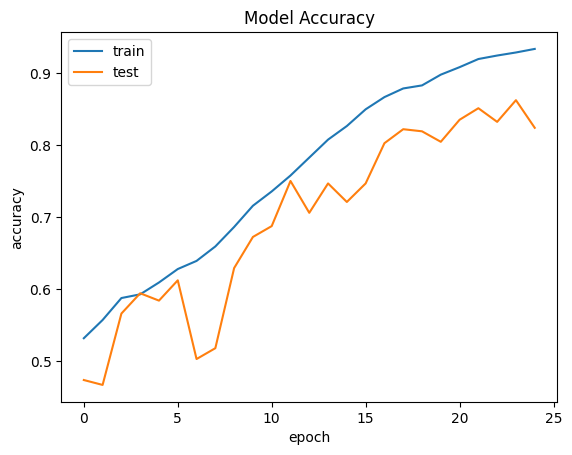

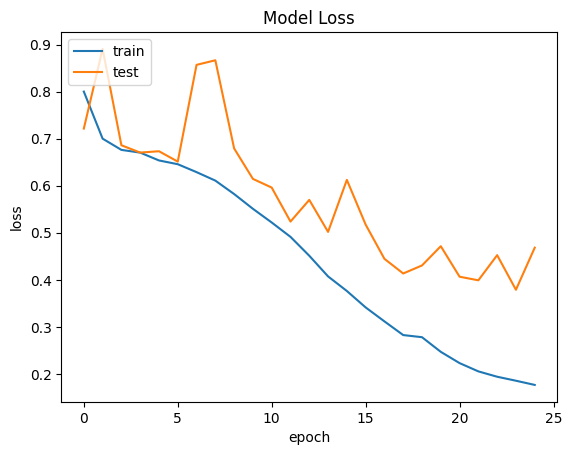

In [ ]:
plt.plot(historyEnhancedCNN.history['accuracy'])
plt.plot(historyEnhancedCNN.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(historyEnhancedCNN.history['loss'])
plt.plot(historyEnhancedCNN.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()